In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, precision_recall_fscore_support,
    ConfusionMatrixDisplay
)

# paths
PROJECT = Path("C:/Users/Admin/Desktop/Projects/turbofan-health-explorer")
PROC = PROJECT / "data" / "processed"
REPORTS = PROJECT / "reports"
REPORTS.mkdir(exist_ok=True)

# load split dataset
df = pd.read_parquet(PROC / "train_FD001_split.parquet")


In [4]:
features = [
    "op1","op2","op3",
    "s2","s3","s4",
    "s2_rollmean","s3_rollmean","s4_rollmean"
]

train_df = df[df["split"] == "train"].copy()
val_df   = df[df["split"] == "val"].copy()
test_df  = df[df["split"] == "test"].copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features])
X_val   = scaler.transform(val_df[features])
X_test  = scaler.transform(test_df[features])

y_train_reg = train_df["RUL"]
y_val_reg   = val_df["RUL"]
y_test_reg  = test_df["RUL"]

le = LabelEncoder()
y_train_cls = le.fit_transform(train_df["health_stage"])
y_val_cls   = le.transform(val_df["health_stage"])
y_test_cls  = le.transform(test_df["health_stage"])


In [5]:
# regression
reg = LinearRegression().fit(X_train, y_train_reg)
y_pred_reg = reg.predict(X_test)

# classification
cls = LogisticRegression(max_iter=1000).fit(X_train, y_train_cls)
y_pred_cls = cls.predict(X_test)
y_proba_cls = cls.predict_proba(X_test)  # optional for later use


In [6]:
acc = accuracy_score(y_test_cls, y_pred_cls)
macro_f1 = f1_score(y_test_cls, y_pred_cls, average="macro")
print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")


Accuracy: 0.676
Macro F1: 0.688


Saved: C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\reports\confusion_matrix_health_stage.png


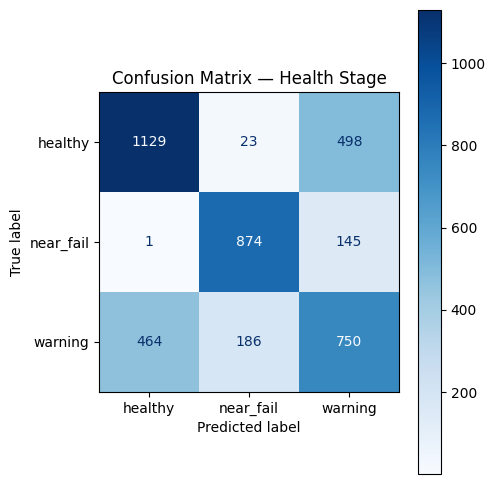

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_cls, y_pred_cls, display_labels=le.classes_, cmap="Blues", ax=ax
)
ax.set_title("Confusion Matrix — Health Stage")
fig.tight_layout()
fig.savefig(REPORTS / "confusion_matrix_health_stage.png", dpi=150)
print("Saved:", REPORTS / "confusion_matrix_health_stage.png")


In [8]:
prec, rec, f1, support = precision_recall_fscore_support(
    y_test_cls, y_pred_cls, labels=np.arange(len(le.classes_))
)
per_class = pd.DataFrame({
    "class": le.classes_,
    "precision": np.round(prec, 3),
    "recall": np.round(rec, 3),
    "f1": np.round(f1, 3),
    "support": support
})
display(per_class)
per_class.to_csv(REPORTS / "per_class_metrics.csv", index=False)


,class,precision,recall,f1,support
0,healthy,0.708,0.684,0.696,1650
1,near_fail,0.807,0.857,0.831,1020
2,warning,0.538,0.536,0.537,1400


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae  = mean_absolute_error(y_test_reg, y_pred_reg)
mse  = mean_squared_error(y_test_reg, y_pred_reg)     # this returns MSE
rmse = np.sqrt(mse)                                   # convert to RMSE
r2   = r2_score(y_test_reg, y_pred_reg)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")


MAE:  31.55
RMSE: 40.69
R2:   0.616


Saved: C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\reports\scatter_pred_vs_true_RUL.png


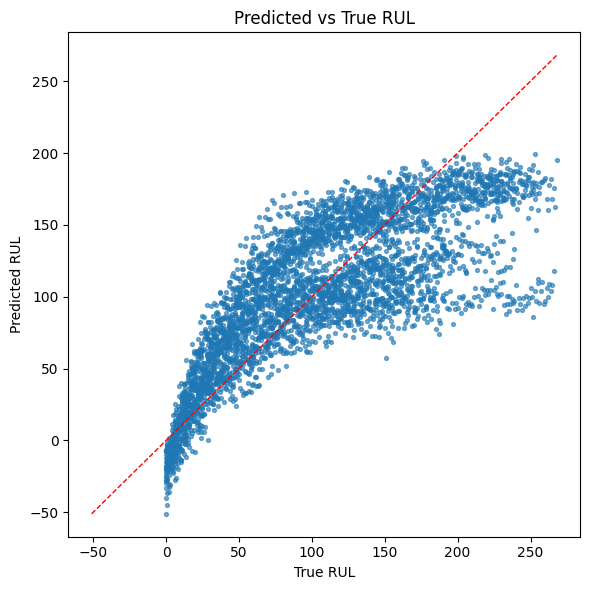

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, s=8, alpha=0.6)
lims = [min(y_test_reg.min(), y_pred_reg.min()), max(y_test_reg.max(), y_pred_reg.max())]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs True RUL")
plt.tight_layout()
plt.savefig(REPORTS / "scatter_pred_vs_true_RUL.png", dpi=150)
print("Saved:", REPORTS / "scatter_pred_vs_true_RUL.png")


Saved: C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\reports\error_vs_cycle_RUL.png


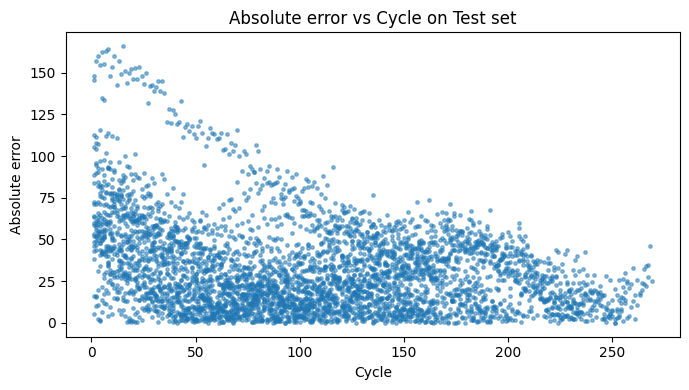

In [11]:
test_err = test_df[["unit","cycle"]].copy()
test_err["true"] = y_test_reg
test_err["pred"] = y_pred_reg
test_err["abs_err"] = (test_err["true"] - test_err["pred"]).abs()

plt.figure(figsize=(7,4))
plt.scatter(test_err["cycle"], test_err["abs_err"], s=6, alpha=0.5)
plt.xlabel("Cycle")
plt.ylabel("Absolute error")
plt.title("Absolute error vs Cycle on Test set")
plt.tight_layout()
plt.savefig(REPORTS / "error_vs_cycle_RUL.png", dpi=150)
print("Saved:", REPORTS / "error_vs_cycle_RUL.png")


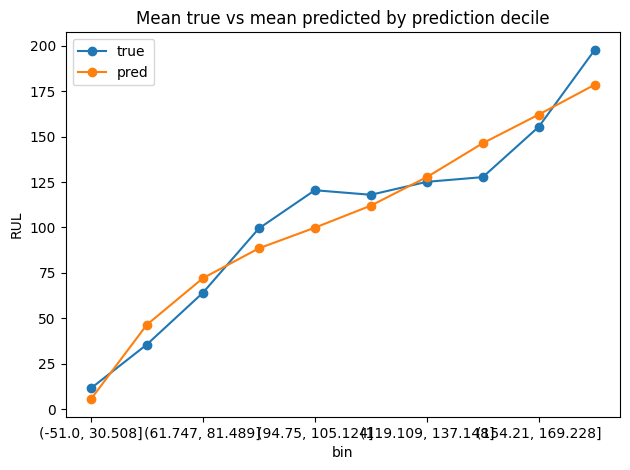

In [19]:
tmp = pd.DataFrame({"true": y_test_reg, "pred": y_pred_reg})
tmp["bin"] = pd.qcut(tmp["pred"], q=10, duplicates="drop")

calib = tmp.groupby("bin", observed=False)[["true", "pred"]].mean()
calib.plot(marker="o")
plt.title("Mean true vs mean predicted by prediction decile")
plt.ylabel("RUL")
plt.tight_layout()
plt.savefig(REPORTS / "calibration_by_decile_RUL.png", dpi=150)


In [16]:
metrics_table = pd.DataFrame([
    {"task": "classification", "metric": "accuracy",  "value": round(acc, 3)},
    {"task": "classification", "metric": "macro_f1",  "value": round(macro_f1, 3)},
    {"task": "regression",     "metric": "MAE",       "value": round(mae, 2)},
    {"task": "regression",     "metric": "RMSE",      "value": round(rmse, 2)},
    {"task": "regression",     "metric": "R2",        "value": round(r2, 3)},
])
display(metrics_table)
metrics_table.to_csv(REPORTS / "final_metrics.csv", index=False)


,task,metric,value
0,classification,accuracy,0.676
1,classification,macro_f1,0.688
2,regression,MAE,31.550
3,regression,RMSE,40.690
4,regression,R2,0.616


In [18]:
from pathlib import Path
FIGS = REPORTS / "figs"
FIGS.mkdir(exist_ok=True)


In [20]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    y_test_cls, y_pred_cls, display_labels=le.classes_, cmap="Blues", ax=ax
)
ax.set_title("Confusion Matrix — Health Stage")
fig.tight_layout()
fig.savefig(FIGS / "confusion.png", dpi=150)
plt.close(fig)

# Predicted vs true RUL scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, s=8, alpha=0.6)
lims = [min(y_test_reg.min(), y_pred_reg.min()), max(y_test_reg.max(), y_pred_reg.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("True RUL"); plt.ylabel("Predicted RUL")
plt.title("Predicted vs True RUL")
plt.tight_layout()
plt.savefig(FIGS / "pred_vs_true_rul.png", dpi=150)
plt.close()

# Error vs cycle
plt.figure(figsize=(7,4))
plt.scatter(test_err["cycle"], test_err["abs_err"], s=6, alpha=0.5)
plt.xlabel("Cycle"); plt.ylabel("Absolute Error")
plt.title("Absolute Error vs Cycle on Test set")
plt.tight_layout()
plt.savefig(FIGS / "error_vs_cycle.png", dpi=150)
plt.close()

# Calibration plot
calib.plot(marker="o")
plt.title("Mean true vs mean predicted by prediction decile")
plt.ylabel("RUL")
plt.tight_layout()
plt.savefig(FIGS / "calibration.png", dpi=150)
plt.close()


In [21]:
import os
os.listdir(FIGS)


['calibration.png',
 'confusion.png',
 'error_vs_cycle.png',
 'pred_vs_true_rul.png']